# Implementing DCGAN

In this notebook, we are implementing DCGAN for Shoes dataset with size of 28701 images. 

### Step 1: Import the needed libraries 


In [11]:
from keras import backend as K
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers import MaxPooling2D, UpSampling2D, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import Model, Sequential
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math   
import os
from tqdm import tqdm
initializer = RandomNormal(mean=0.0, stddev=0.01, seed=None)
%matplotlib inline

### Step 2: Data Loading
The data used in this notebook is the cleaned one with around 14000 images 

In [12]:
# load Fashion Product Images dataset
width=100
batch_size=100 # batch size of image generator = batch size of GAN
path = '/home/group6/G.Deep Learning/Project/Shoes-dataset'
Img_generator=ImageDataGenerator(rescale=1./255)
train_gen=Img_generator.flow_from_directory(path, classes=[''], target_size=(width,width),batch_size=batch_size,shuffle=False)

Found 28701 images belonging to 1 classes.


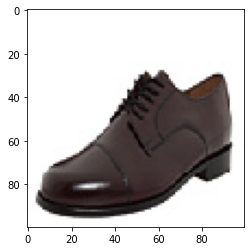

In [13]:
d = (train_gen.next())
train_gen.reset()
d[0][0].shape
plt.imshow(d[0][0])

In [14]:
img_shape = (width, width, 3)
z_dim = 100
num_batches = math.floor(28701/batch_size)
num_batches

287

### Step 3: DCGAN Implementation


### Generator

In [5]:
def build_generator(input_shape, inputs=(100, )):
    """Build a Generator Model
    Stack of BN-ReLU-Conv2DTranpose to generate fake images
    Output activation is sigmoid instead of tanh in [1].
    Sigmoid converges easily.
    Arguments:
        inputs (Layer): Input layer of the generator 
            the z-vector)
        image_size (tensor): Target size of one side
            (assuming square image)
    Returns:
        generator (Model): Generator Model
    """
    # network parameters 
    kernel_size = 3
    layer_filters = [128, 64, 32, 3]
   
    # We will start with 7x7x128 and upscale to 28x28x1 evantually
    inputs = Input(shape=inputs, name='Generator')
    print(input_shape[0])
    print(layer_filters[0])
    resize = input_shape[0] // 4
    x = Dense(resize * resize * layer_filters[0])(inputs)
    x = Reshape((resize, resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    generator = Model(inputs, x, name='generator')
    generator.summary()
    return generator

### Discriminator

In [6]:
def build_discriminator(input_shape = (100, 100 ,3)):
    """Build a Discriminator Model
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in [1] or original paper.
    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256, 512]  #[32, 64, 128, 256]

    inputs = Input(shape=input_shape, name='discriminator_input')
    x = inputs
    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = Activation('relu')(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
#     x = Dropout(0.4)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')
    discriminator.summary()
    return discriminator

### Training 

In [7]:
accuracies = []
losses = []
def train(train_gen, epochs, generator_batch_size, ite_to_save=100):
    real = np.ones(shape=(generator_batch_size, 1))
    fake = np.zeros(shape=(generator_batch_size, 1))
    
    for epoch in tqdm(range(epochs)):
        train_gen.reset() #To insure that we start again from the same batch (0)
        for batch in range(num_batches):
            #load current batch
            x_train = train_gen.next()
        
            real_images=x_train[0][0:generator_batch_size]   
            
            z = np.random.normal(0, 1, size=[generator_batch_size, z_dim]) 
            gen_imgs = gen.predict(z)
        
            d_loss_real = disc.train_on_batch(real_images, real)
            d_loss_fake = disc.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
            z = np.random.normal(0, 1, size=[generator_batch_size, z_dim])
        
            g_loss = DCGAN.train_on_batch(z, real)
            
        print('{} [D loss: {}, accuracy: {:.2f}] [Adv loss: {}, Adv accuracy: {:.2f}]'.format(epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1]))
        
        losses.append([d_loss[0], g_loss[0]])
        accuracies.append([d_loss[1], g_loss[1]])
        if epoch % ite_to_save == 0:    
            plot_images(gen,
                z,
                show=True,
                file_name="images/Latent100/Epoch_{}.png".format(epoch))
            disc.save('savedModelsDCLatent100/dcdisc_{}.h5'.format(epoch))  
            gen.save('savedModelsDCLatent100/dcgen_{}.h5'.format(epoch))  
            DCGAN.save('savedModelsDCLatent100/dcGAN_{}.h5'.format(epoch))   
    

### Plot Images

In [15]:
# predict images
def plot_images(generator,
                noise_input,
                show=False,
                file_name="images/Latent100/Epoch_1.png"):
    z = noise_input
    gen_imgs = generator.predict(z)
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(gen_imgs[i].reshape(100, 100, 3)) #Draw the first 10 img in the first batch
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig(file_name)    
    plt.show()

### Building the model

In [9]:
# Building and compiling the discriminator
# Since there are only two classes

disc = build_discriminator(img_shape) 
#discriminator = define_discriminator() 
disc.compile(loss='binary_crossentropy', 
                      optimizer=Adam(0.0002, beta_1=0.5), 
                      metrics=['accuracy']) 

#Making the Discriminator untrainable 
#so that the generator can learn from fixed gradient 
disc.trainable = False
  
# Building the generator 
gen = build_generator(img_shape, (z_dim, ))
  
#Defining the input for the generator 
#and generating the images 
z = Input(shape=(z_dim,)) 
print("Z=", z)
image = gen(z)
print("Image=", image)
print("Image SHAPE {}".format(image.shape))
#Checking the validity of the generated image
#Feed the image into the discriminator

valid = disc(image)
print("Valid=",valid)
  
#Defining the combined model of the Generator and the Discriminator 
DCGAN = Model(z, valid) 
DCGAN.compile(loss='binary_crossentropy', 
                         optimizer=Adam(0.0002, beta_1=0.5),
                         metrics=['accuracy']) 


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 100, 100, 3)]     0         
_________________________________________________________________
activation (Activation)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        2432      
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)     

### Start Training

In [16]:
epochs = 201
batch_size = 100
ite_to_save = 5
# need to add these for the GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

train(train_gen, epochs, batch_size, ite_to_save)

NameError: name 'train' is not defined

In [17]:
#Plot the final results 
noise_input = np.random.normal(0, 1, size=[100, z_dim])
plot_images(gen, noise_input,
            show=True,
            file_name="images/Latent100/2000000")

NameError: name 'gen' is not defined

#### Plot the Losses Accuracies for Discriminator and Adversarial

In [12]:
loss_history = np.array(losses)
acc_history = np.array(accuracies)

dloss = loss_history[:, 0]
dacc = acc_history[:, 0]

advloss = loss_history[:, 1]
advacc = acc_history[:, 1]

print(dloss.shape)

(201,)


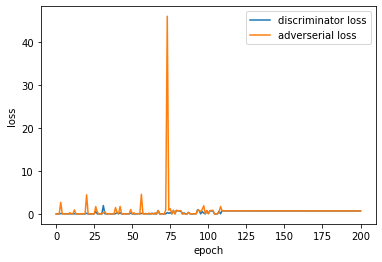

In [13]:
# let us plot the loss vs. epochs
epoch = np.arange(0,len(dloss))
fig, ax = plt.subplots()
ax.plot(epoch, dloss,label='discriminator loss')
ax.plot(epoch, advloss,label='adverserial loss')
leg = ax.legend();
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

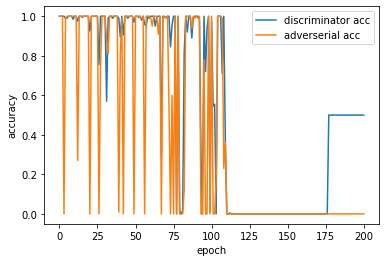

In [14]:
# let us plot the loss vs. epochs
epoch = np.arange(0,len(dloss))
fig, ax = plt.subplots()
ax.plot(epoch, dacc,label='discriminator acc')
ax.plot(epoch, advacc,label='adverserial acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
leg = ax.legend();
plt.show()

In [18]:
#Defining the combined model of the Generator and the Discriminator 
generater_loaded = tf.keras.models.load_model('savedModelsDCLatent100/dcgen_200.h5') 
generater_loaded.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80000)             8080000   
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 25, 128)       512       
_________________________________________________________________
activation_6 (Activation)    (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 50, 50, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 128)       51

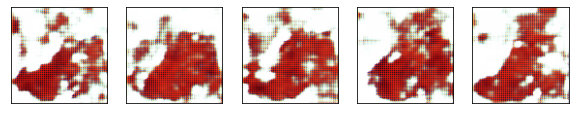

In [23]:
z = noise_input
gen_imgs = generater_loaded.predict(z)
n = 5  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
        # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(gen_imgs[i].reshape(100, 100, 3)) #Draw the first 10 img in the first batch
    #     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()